In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit
from ase.units import kB

# Initial configuration

In [54]:
# random choice among [0,1,2]
def initial_state(N):
  config = np.random.choice(list(range(len(J))), size=(N, N))
  return config

# Fixing molar fraction (Xi)
# (X0, X1, X2) = (133, 133, 134)
# grid = np.array(X0*[0]+X1*[1]+X2*[2])
# np.random.shuffle(grid)
# grid = grid.reshape((N,N))

In [118]:
@njit
def calculate_energy(config, J):
    energy = 0
    for i in range(N):
        for j in range(N):
            for di, dj in [(1, 0), (0, 1), (-1, 0), (0, -1)]: # square lattice
                ni, nj = (i + di) % N, (j + dj) % N
                energy += J[config[i, j], config[ni, nj]]
    return energy / 2.

@njit
def calculate_warrencowley(config, J):
    """Calculate the Warren-Cowley parameters to measure the short-range order (SRO) in alloys."""
    N = config.shape[0] # Number of points in grid
    E = len(J) # Number of element types
    count = np.zeros(E)
    occurrence = np.zeros((E,E))
    
    for i in range(N):
        for j in range(N):
            current_type = config[i, j]
            count[config[i, j]] += 1
            for di, dj in [(1,0), (0,1), (-1,0), (0,-1)]:
                ni, nj = (i + di) % N, (j + dj) % N
                neighbor_type = config[ni, nj]
                occurrence[current_type, neighbor_type] += 1

    coordination_number = 4
    normalization = np.where(count > 0, count, 1)
    normalized_prob = occurrence.T / (coordination_number*normalization)

    identity = np.identity(E)
    alpha = identity - normalized_prob.T
    return alpha

def calculate_omega(alpha):
    n = len(alpha)
    upper_triangle = np.triu(alpha**2, k=1)
    sum_upper = np.sum(upper_triangle)
    return np.sqrt(sum_upper/(n*(n-1)/2))

def mc_move(config, beta, J):
    """Perform Monte Carlo moves with the constraint of equal numbers of up and down spins."""
    N = config.shape[0]
    for _ in range(N*N):
        # Save original configuration
        original_config = np.copy(config)

        # Selecting spins to swap
        i1, j1 = np.random.randint(0, N, size=2)
        i2, j2 = np.random.randint(0, N, size=2)
        while (i1, j1) == (i2, j2):  # Ensure they are different
            i2, j2 = np.random.randint(0, N, size=2)
                
        # Swap the spins
        config[i1, j1], config[i2, j2] = config[i2, j2], config[i1, j1]
        
        delta_E = calculate_energy(config, J) - calculate_energy(original_config, J)
        
        if delta_E > 0 and np.random.rand() >= np.exp(-delta_E * beta):
            # Revert the swap if the move is not energetically favorable
            config[...] = original_config

def ising_model_subprocess(args):
    N, mc_steps, T, J = args
    config = initial_state(N)
    beta = 1.0/T

    for _ in tqdm(range(mc_steps)):
        mc_move(config, beta, J)

    return config

def parallel_ising_model(N=10, mc_steps=500, T=1.0, J=1.0, num_processes=4):
    pool = Pool(processes=num_processes)
    args = [(N, mc_steps // num_processes, T, J) for _ in range(num_processes)]
    results = pool.map(ising_model_subprocess, args)
    pool.close()
    pool.join()
    return  results[0]

def ising_model(N=10, mc_steps=500, T=1.0, J=np.identity(3)):
    config = initial_state(N)
    beta = 1.0/T
    for _ in tqdm(range(mc_steps)):
        mc_move(config, beta, J)

    return config


In [119]:
# Parameters
N = 100  # Dimensions of the grid (NxN)

# Interaction matrix
             # Cu,Al,Ni
# J = np.array([[ 0.000,-0.200, 0.100],  # Cu
#               [-0.236, 0.000,-0.200],  # Al
#               [ 0.099,-0.200, 0.000]]) # Ni

J = np.array([[ 0.000, 0.200, 0.100],  # Cu
              [ 0.200, 0.000, 0.200],  # Al
              [ 0.100, 0.200, 0.000]]) # Ni

T = 300  # Temperature (in K)
kT = T * kB # Temperature (in eV)
mc_steps = 500

config = ising_model(N, mc_steps, kT, J)


100%|██████████| 500/500 [11:18<00:00,  1.36s/it]


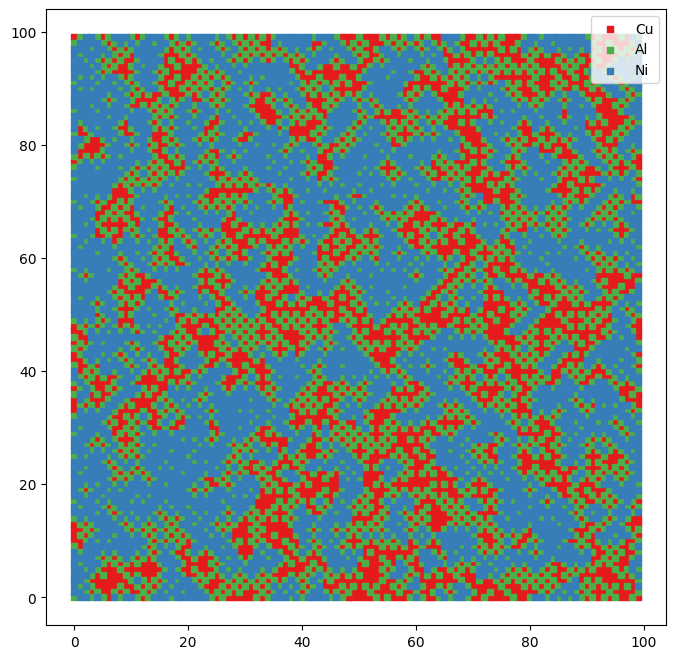

In [116]:
colors = ['#e41a1c', '#4daf4a', '#377eb8']
# colors = ['#1b9e77', '#d95f02', '#7570b3']
labels = ['Cu', 'Al', 'Ni']

plt.figure(figsize=(8, 8))
for i in range(3):
    plt.scatter(*np.where(config == i), color=colors[i], s=15, marker='s', alpha=1.0, label=labels[i])
    # plt.scatter(*np.where(config == i), edgecolors=None, color=colors[i], s=5, marker='o')

# i=0
# plt.scatter(*np.where(config == i), color=colors[i], s=5, marker='o', alpha=1.0, label=labels[i])
plt.legend()
plt.show()